In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
warnings.filterwarnings(action='ignore')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_trend.trend_lstm import LSTMModel_trend

In [2]:
### morning data
with open('../data/preprocess/m_data_list.pkl', 'rb') as f:
#with open('data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/full_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)
data_list = append_cycle_size(data_list)
data_list = append_trend_size(data_list)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [5]:
# Load model
model_trend = LSTMModel_trend(input_size = 12, hidden_size = 32, no_time_size =5).to(device)

In [6]:
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
num_epochs  = 300
hist = np.zeros(num_epochs)

train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model_trend(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,0]) ### trend
    train_error.append(loss)

    valid_trend_pred = model_trend(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,0]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model_trend, 'models/best_trends.pkl')

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
best_model = torch.load('models/best_trends.pkl')


10 Epochs train MSE: 0.48287 // valid MSE: 0.24109
20 Epochs train MSE: 0.19160 // valid MSE: 0.11263
30 Epochs train MSE: 0.04217 // valid MSE: 0.04492
40 Epochs train MSE: 0.02403 // valid MSE: 0.03349
50 Epochs train MSE: 0.01999 // valid MSE: 0.02815
60 Epochs train MSE: 0.01688 // valid MSE: 0.02691
70 Epochs train MSE: 0.01432 // valid MSE: 0.02536
80 Epochs train MSE: 0.01209 // valid MSE: 0.02263
90 Epochs train MSE: 0.01065 // valid MSE: 0.02137
100 Epochs train MSE: 0.00990 // valid MSE: 0.02051
110 Epochs train MSE: 0.00936 // valid MSE: 0.02003
120 Epochs train MSE: 0.00893 // valid MSE: 0.01992
130 Epochs train MSE: 0.00862 // valid MSE: 0.02006
140 Epochs train MSE: 0.00877 // valid MSE: 0.01968
150 Epochs train MSE: 0.00810 // valid MSE: 0.01993
160 Epochs train MSE: 0.00772 // valid MSE: 0.01948
170 Epochs train MSE: 0.00747 // valid MSE: 0.01923
180 Epochs train MSE: 0.00722 // valid MSE: 0.01919
190 Epochs train MSE: 0.00701 // valid MSE: 0.01922
200 Epochs train MSE:

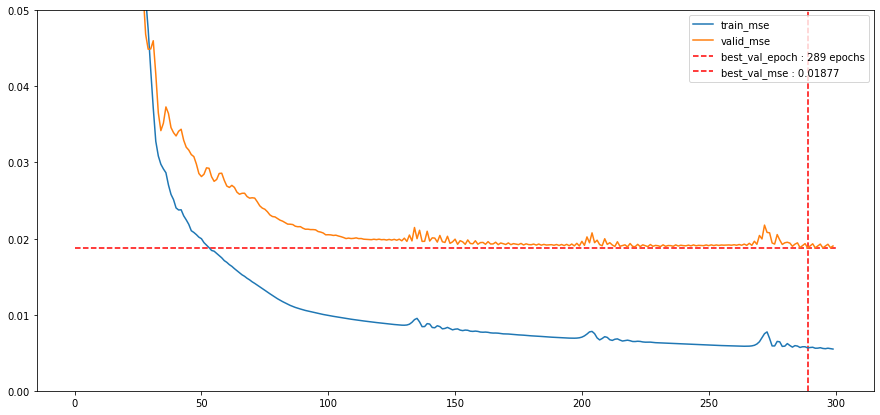

In [11]:
# no time time 곱하기
# cycle size 더하기

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = num_epochs,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

In [7]:
# trend
i = 0
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

x = torch.cat((train_time[:,-7:,(i-2)], valid_time[:,-7:,(i-2)], test_time[:,-7:,(i-2)]))
print('last week error : ',np.array(criterion(x, y).cpu()))

morning trend
zeros error :  0.5131335
random normal error :  1.5051937
last week error :  0.01637041


In [8]:
print("morning trend results")

train_pred = model_trend(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,0]))

valid_pred = model_trend(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,0]))

test_pred = model_trend(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,0]))

morning trend results
train_error :  tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward>)
test_error :  tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward>)


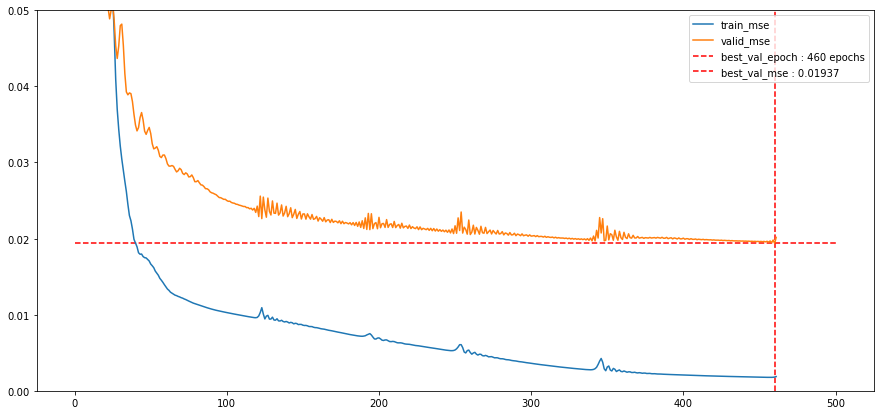

In [10]:
# no time time 곱하기
# cycle size 더하기
# trend size 더하기

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

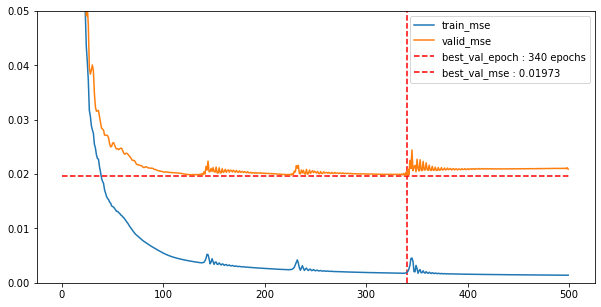

In [10]:
# no time time 곱하기
# cycle size 더하기
# trend size 더하기

plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

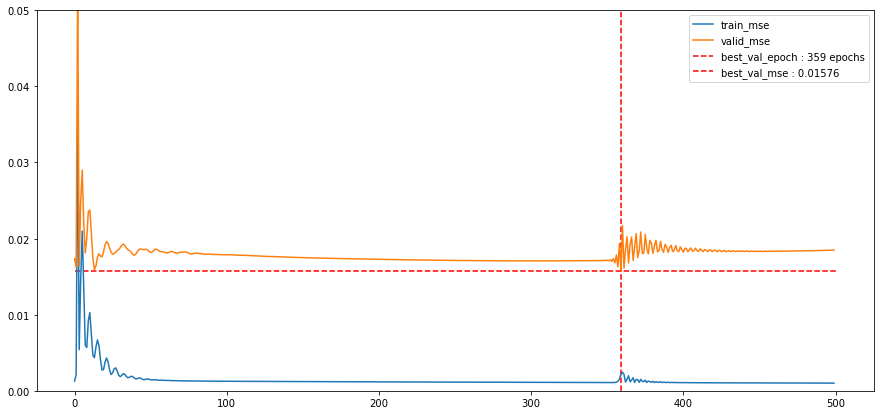

In [8]:
# no time time 곱하기
# cycle size 더하기

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

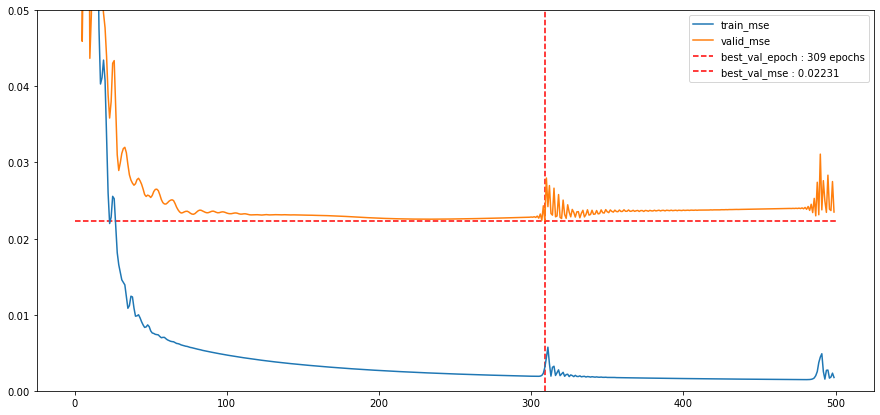

In [22]:
# no time time 곱하기
# cycle size 더하기

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

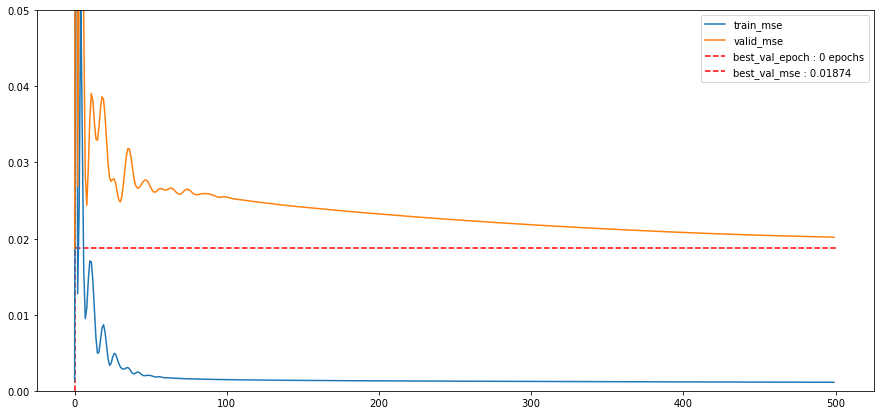

In [10]:
# no time time 곱하기

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

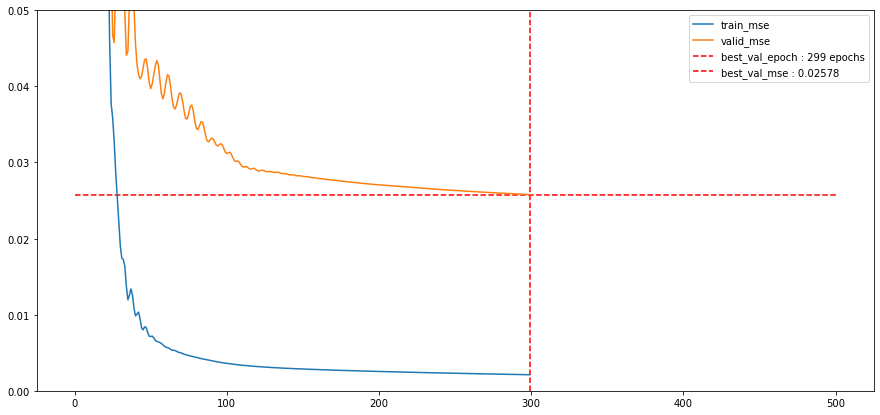

In [11]:
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

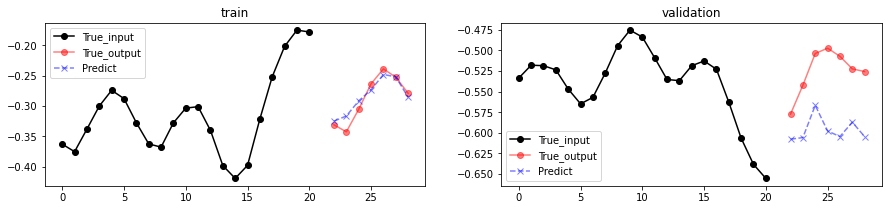

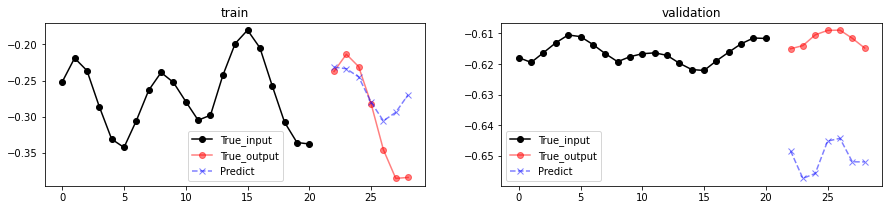

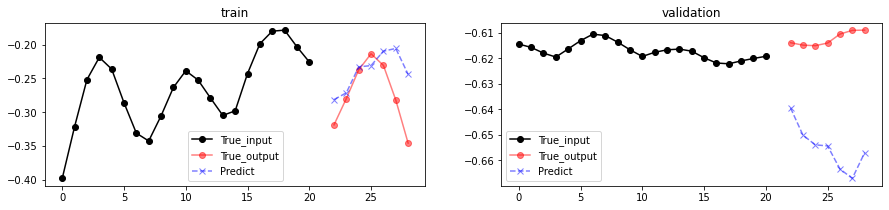

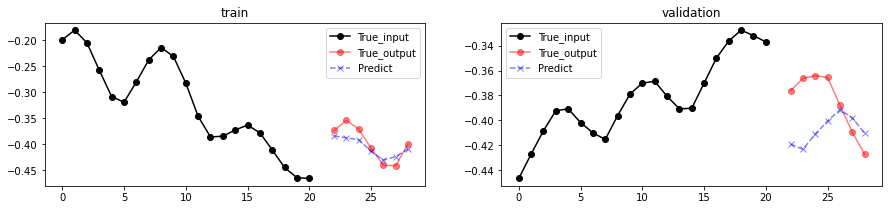

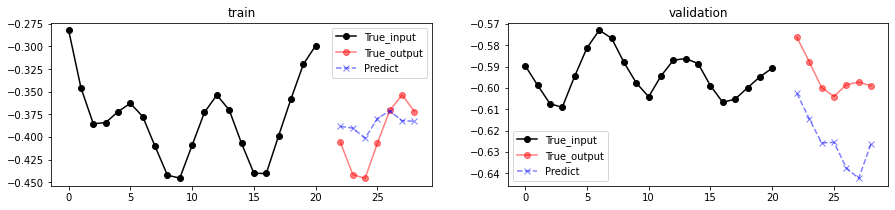

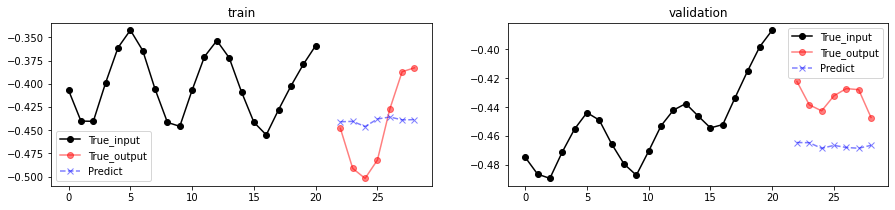

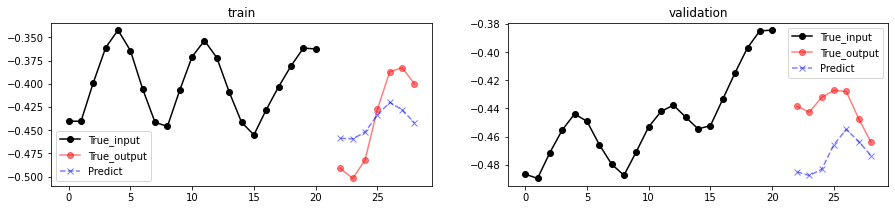

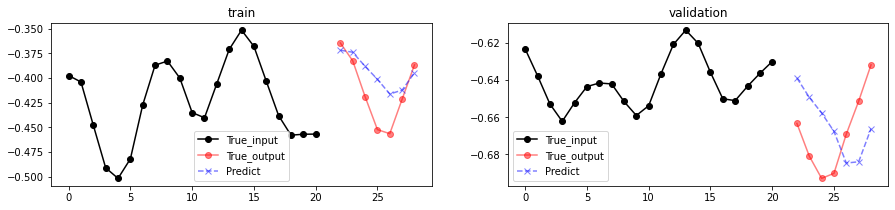

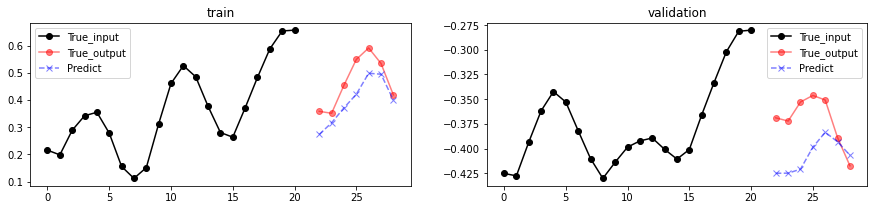

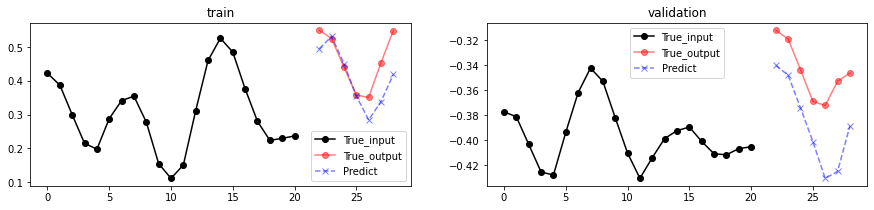

In [9]:
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np= tensor2numpy([train_time[:,:,-2], train_y[:,:,0], train_trend_pred,
                                                        valid_time[:,:,-2], valid_y[:,:,0], valid_trend_pred])

plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

trend_result_list = [train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np]

### morning result
path = '../data/train_results/morning_results/'
with open(path + 'm_trend_results_list.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

In [18]:
test_pred_np.shape

(690, 7)

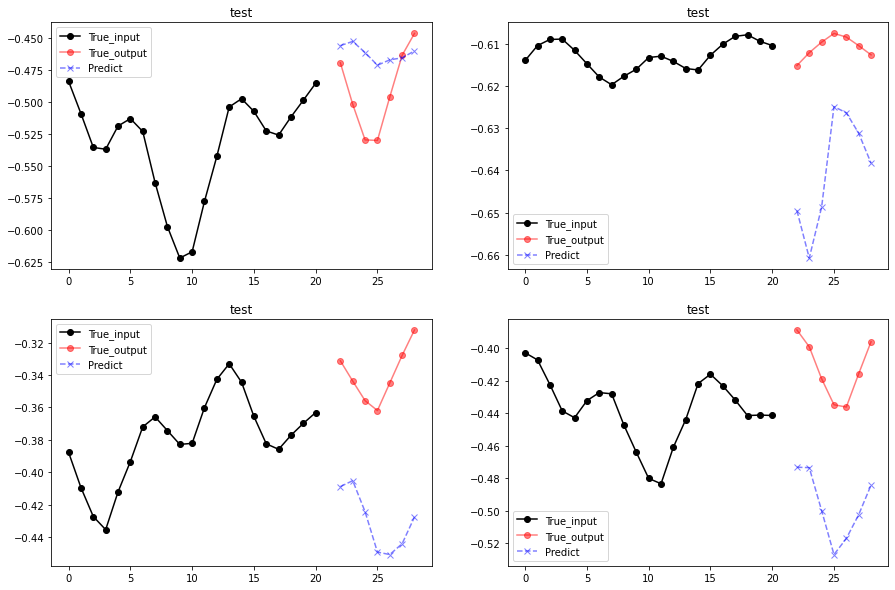

In [11]:
train_pred = model_trend(train_time, train_notime)
test_pred = model_trend(test_time, test_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([train_time[:,:,-2], train_y[:,:,0], train_pred,
                                                        test_time[:,:,-2], test_y[:,:,0], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    test_time_x_np, test_y_np, test_pred_np]

In [9]:
def plot_test_predict(train_x, train_y, train_pred):
    plt.figure(figsize = (15, 10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        i = random.randint(1,21) + i*11
        plt.plot(np.arange(21), train_x[i,:],   # m_train_time.cpu().detach().numpy()[i,:,-2],
                marker = 'o', color = 'black', label = 'True_input')
        plt.plot(np.arange(22,29), train_y[i],    #m_train_y[:,:,0].cpu().detach().numpy()[i],
                marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
        plt.plot(np.arange(22,29),train_pred[i],    #.cpu().detach().numpy()[i],
                color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
        plt.title('test')
        plt.legend()
    plt.show()
